# Detección de localización de aviones
Teniendo en cuenta el artículo [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://doi.org/10.48550/arXiv.1506.01497) se propone una estrategia para detectar la localización de aviones a partir de imágenes usando anchor boxes, con el siguiente flujo de trabajo:
1. **Preparación de las etiquetas**.
Se cargan, visualizan y normalizan las etiquetas, preparándolas para ingresar a la red.
2. **Extracción de características con una red preentrenada y cabeza de regresión**.
Se definen las estructuras de datos para trabajar con pytorch y el modelo como tal. 
El modelo creado, llamado `BoundingBoxRegressor` se construye con un backbone de `ResNet18` preentrenada en ImageNet. Se escoge esta red por su rapidez y robustez, además de su estructura modular que permite modificarla para otras tareas como la regresión en este caso, simplemente eliminando la capa de salida. 
De este modo se eliminan las ultimas dos capas `avpool` y `fc`, añadiendo un pooling global y la cabeza de regresión. Por medio de esta capa fully connected se transforma la última capa de activación de `ResNet18` en una salida de cuatro canales, correspondientes a la predicción de las coordenadas del objeto. Esto se muestra en el siquiente esquema:

```bash
BoundingBoxRegressor/
├── Backbone: ResNet18 (preentrenado, sin avgpool ni fc)
├── AdaptiveAvgPool2d (1x1)
├── Regressor Head
│   ├── Linear (512 → 128)
│   ├── ReLU
│   ├── Linear (128 → 4)
│   └── Sigmoid (para mantener salida en [0, 1])
└── Salida: [x_min, y_min, x_max, y_max]

```

## 1. Preparación de etiquetas
### Carga y visualización de etiquetas

In [ ]:
# Carga de librerías
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize, Normalize, Compose
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm import tqdm

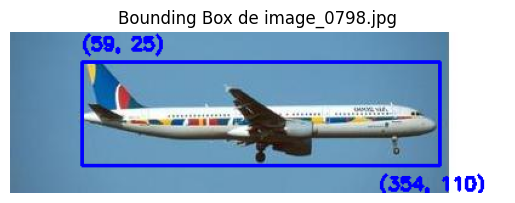

Tamaño de la imagen: 133x409
Coordenadas de los boxes: [[ 59  25 354 110]]


(None, None, None)

In [81]:
# Cargar etiquetas
df = pd.read_csv('data\Airplanes.csv') 

# Renombrar las columnas (por laguna razón estaban trocadas)
df.rename(columns={'x_top': 'y1', 
                   'y_top': 'y2', 
                   'x_bottom': 'x1', 
                   'y_bottom': 'x2'}, inplace=True)

# Establecer una imagen aleatoria como ejemplo
sample_image = df.sample(1).iloc[0]['Image']
IMG_ROUTE = 'data\images'
imagen = cv2.imread(os.path.join(IMG_ROUTE, sample_image))
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Funcion para dibujar bounding boxes y mostrar la imagen
def draw_bounding_boxes(image, df, sample_image):
    # Filtrar el DataFrame para obtener las filas correspondientes a la imagen seleccionada
    df_sample = df[df['Image'] == sample_image]
    
    # Dibujar cada bounding box en la imagen
    for _, row in df_sample.iterrows():
        x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
        # Dibujar el rectángulo y la etiqueta
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        # Añadir etiqueta de coordenadas
        cv2.putText(image, f'({x1}, {y1})', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.putText(image, f'({x2}, {y2})', (x2 - 50, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        # Añadir a imagen con matplotlib
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Bounding Box de {sample_image}')
        
    return plt.show(), print(f'Tamaño de la imagen: {imagen.shape[0]}x{imagen.shape[1]}'), print(f'Coordenadas de los boxes: {df_sample[["x1", "y1", "x2", "y2"]].values}')

# Llamar a la función para dibujar el bounding box
draw_bounding_boxes(imagen, df, sample_image)

Gracias a esta exploración inicial fue que pudimos observar que los nombres de las columnas del csv original estaban trocadas, además de que todas las imagenes tienen tamaños diferentes. Esto es fundamental saberlo para lo siguiente.

### Normalizar etiquetas
Pasaremos a convertir los valores de píxel absoluto a valores entre 0 y 1 para entrenamiento

In [29]:
# Definir una funcion para normalizar
def normalize_bounding_boxes(df, img_dir):
    df_norm = df.copy()
    # Convertir columnas a float antes de dividir
    df_norm[['x1', 'x2', 'y1', 'y2']] = df_norm[['x1', 'x2', 'y1', 'y2']].astype(float)
    for img_name in df['Image'].unique():
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            idx = df_norm['Image'] == img_name
            df_norm.loc[idx, ['x1', 'x2']] /= w
            df_norm.loc[idx, ['y1', 'y2']] /= h
    return df_norm

df_normalized = normalize_bounding_boxes(df, IMG_ROUTE)

In [83]:
df_normalized.describe()

,Unnamed: 0,y1,y2,x1,x2
count,800.0,800.000000,800.000000,800.000000,800.000000
mean,0.0,0.202458,0.807550,0.134610,0.863425
std,0.0,0.048653,0.037939,0.018959,0.024640
min,0.0,0.019048,0.230303,0.059850,0.321429
25%,0.0,0.180124,0.794728,0.125000,0.858223
50%,0.0,0.195946,0.812081,0.133995,0.867500
75%,0.0,0.215712,0.827205,0.143211,0.873205
max,0.0,0.421384,0.976608,0.265306,0.900763


Con este resumen estadístico podemos ver que efectivamente las coordenadas quedaron normalizadas, además que la distribución de los datos por coordenada tiene sentido (coordenadas x1, y1 no sobrepasan el 50% de los datos y coordenadas x2,y2 se conservan por encima del tercer cuantil)

## 2. Extracción de características y regresión
Primero creamos una nueva clase basada en `Dataset` de pytorch para que cargue las imagenes junto con sus cuadros delimitadores de una manera adecuada para el entrenamiento de los modelos.
### Creación del Dataset

In [ ]:
class BboxDataset(Dataset):
    def __init__(self, dataframe, image_dir, image_size=(224, 224)):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = Compose([
            Resize(image_size),  # Redimensionar todas las imágenes
            
            Normalize(mean=[0.485, 0.456, 0.406],  # Normalizar imagen al estilo ImageNet
                      std=[0.229, 0.224, 0.225]),
        ])
        self.image_size = image_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['Image'])
        image = read_image(img_path).float() / 255.0  # Cargar y normalizar a [0,1]
        # Redimensionar y normalizar la imagen
        image = self.transform(image)
        # Transformar a tensor las coordenadas de los bounding boxes
        target = torch.tensor([row['x1'], row['y1'], row['x2'], row['y2']], dtype=torch.float32)

        return image, target


### Deinición del Dataloader
Ahora creamos el dataloader para un procesamiento eficiente.

In [51]:
# Dividir el DataFrame en conjuntos de entrenamiento y validación
df_train, df_temp = train_test_split(df_normalized, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Imprimir el tamaño de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {len(df_train)}')
print(f'Tamaño del conjunto de validación: {len(df_val)}')
print(f'Tamaño del conjunto de prueba: {len(df_test)}')

train_dataset = BboxDataset(df_train, IMG_ROUTE)
val_dataset = BboxDataset(df_val, IMG_ROUTE)
test_dataset = BboxDataset(df_test, IMG_ROUTE)

# Crear DataLoaders para los conjuntos de entrenamiento y validación
batchize = 16
train_loader = DataLoader(train_dataset, batch_size=batchize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Tamaño del conjunto de entrenamiento: 560
Tamaño del conjunto de validación: 120
Tamaño del conjunto de prueba: 120


### Definicion del modelo
Como se explicó al principio con `ResNet18` + capa lineal 

In [52]:
class BoundingBoxRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Quitamos avgpool y fc
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling global
        # Red regresora para predecir las coordenadas del bounding box
        self.regresor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),  # Salida con 4 valores (x1, y1, x2, y2)
            nn.Sigmoid()        # Aseguramos que salidas estén en [0, 1]
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        return self.regresor(x)

In [ ]:
# Establecer el modelo, dispositivo, función de pérdida y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Envia a GPU si está disponible
model = BoundingBoxRegressor().to(device)  # Instanciar el modelo y enviarlo al dispositivo
# Definir la función de pérdida y el optimizador
loss_fn = nn.MSELoss()  # Pérdida de error cuadrático medio para regresión
learning_rate = 0.001
optimizer = Adam(model.parameters(), lr=learning_rate)  # Optimizador Adam

### Entrenamiento

In [54]:
def train_epoch(model, loader):
    model.train()
    running_loss = 0.0
    for imgs, targets in tqdm(loader, desc="Entrenando"):
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, targets)
            running_loss += loss.item()
    return running_loss / len(loader)

# Entrenamiento completo
for epoch in range(10):
    train_loss = train_epoch(model, train_loader)
    val_loss = validate(model, val_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Entrenando: 100%|██████████| 35/35 [01:40<00:00,  2.88s/it]


[Epoch 1] Train Loss: 0.0130 | Val Loss: 0.0017


Entrenando: 100%|██████████| 35/35 [01:56<00:00,  3.32s/it]


[Epoch 2] Train Loss: 0.0028 | Val Loss: 0.0034


Entrenando: 100%|██████████| 35/35 [01:51<00:00,  3.20s/it]


[Epoch 3] Train Loss: 0.0021 | Val Loss: 0.0021


Entrenando: 100%|██████████| 35/35 [01:49<00:00,  3.14s/it]


[Epoch 4] Train Loss: 0.0016 | Val Loss: 0.0016


Entrenando: 100%|██████████| 35/35 [01:54<00:00,  3.27s/it]


[Epoch 5] Train Loss: 0.0015 | Val Loss: 0.0008


Entrenando: 100%|██████████| 35/35 [01:54<00:00,  3.26s/it]


[Epoch 6] Train Loss: 0.0015 | Val Loss: 0.0084


Entrenando: 100%|██████████| 35/35 [00:53<00:00,  1.53s/it]


[Epoch 7] Train Loss: 0.0015 | Val Loss: 0.0017


Entrenando: 100%|██████████| 35/35 [01:03<00:00,  1.82s/it]


[Epoch 8] Train Loss: 0.0013 | Val Loss: 0.0017


Entrenando: 100%|██████████| 35/35 [00:44<00:00,  1.27s/it]


[Epoch 9] Train Loss: 0.0014 | Val Loss: 0.0023


Entrenando: 100%|██████████| 35/35 [00:44<00:00,  1.27s/it]


[Epoch 10] Train Loss: 0.0011 | Val Loss: 0.0020


Se observa que solo con 10 épocas hay un entrenamiento consistente, donde va descendiendo la función de pérdida de entrenameinto (aunque no es suficiente para que se estabilice y de esta forma decir que el entrenamiento fue completado en su totalidad). Por otra parte la pérdida de validación es inestable lo que puede significar que el dataset de validación es poco representativo o demasiado pequeño. Es claro que 120 muestras no es suficiente, pero lo será en este caso para fines demostrativos.

### Evaluación con IoU
Primero se define la función de IoU y se calcula para todas las imagenes del conjunto de testeo. 

In [ ]:
def calcular_iou(pred, target):
    # pred y target: [x1, y1, x2, y2] normalizados
    xA = torch.max(pred[0], target[0])
    yA = torch.max(pred[1], target[1])
    xB = torch.min(pred[2], target[2])
    yB = torch.min(pred[3], target[3])

    inter = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)
    area_pred = (pred[2] - pred[0]) * (pred[3] - pred[1])
    area_target = (target[2] - target[0]) * (target[3] - target[1])
    union = area_pred + area_target - inter
    return (inter / union).item() if union > 0 else 0.0


In [56]:
# Inicializar lista para almacenar IoU
ious = []
model.eval() # Establecer el modelo en modo evaluación

with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Test IoU"):
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs).squeeze(0).cpu()
        targets = targets.squeeze(0).cpu()
        iou = calcular_iou(preds, targets)
        ious.append(iou)

print(f"IoU promedio en test: {sum(ious)/len(ious):.4f}")

Test IoU: 100%|██████████| 120/120 [00:05<00:00, 22.86it/s]


IoU promedio en test: 0.8759


Se puede observar que se alcanza una métrica responsable, aún con las pocas muestras y los detalles en la evaluación del modelo comentados anteriormente.

## Resultados y visualización de predicciones

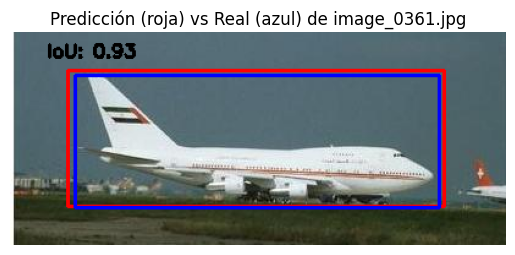

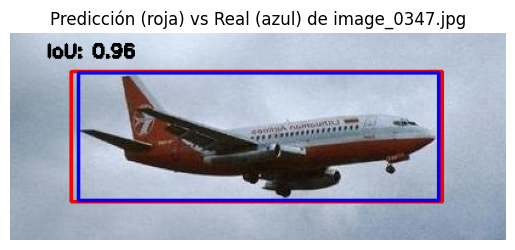

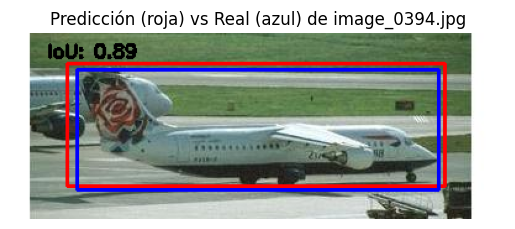

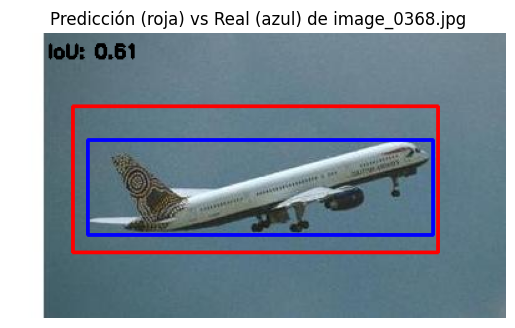

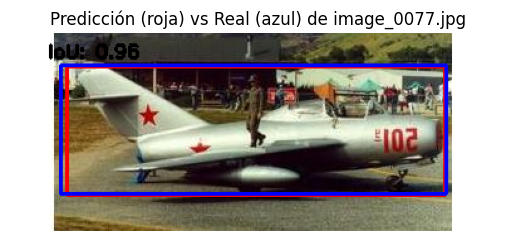

In [89]:
# Se define una función para denormalizar las coordenadas del bounding box
# para que se puedan visualizar correctamente en la imagen original
def denormalizar_bbox(bbox, image):
    h, w = image.shape[:2]
    return [
        int(bbox[0] * w), int(bbox[1] * h),
        int(bbox[2] * w), int(bbox[3] * h)
    ]

# Mostrar algunas predicciones
model.eval()
for i, (img, target) in enumerate(test_loader):
    # Se toman las primeras 5 imágenes del conjunto de prueba
    if i >= 5: break
    img_tensor, targets = img.to(device), target.to(device)
    pred = model(img_tensor).squeeze(0).cpu()
    target = target.squeeze(0).cpu()

    # Cargar la ruta de la imagen original correspondiente
    img_path = os.path.join(IMG_ROUTE, df_test.iloc[i]['Image'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Denormalizar las coordenadas del bounding box real y predicho
    pred_coords = denormalizar_bbox(pred, image)
    target_coords = denormalizar_bbox(target, image)

    # Dibujar cajas
    cv2.rectangle(image, (pred_coords[0], pred_coords[1]),
                  (pred_coords[2], pred_coords[3]), (255, 0, 0), 2)
    cv2.rectangle(image, (target_coords[0], target_coords[1]),
                  (target_coords[2], target_coords[3]), (0, 0, 255), 2)
    
    # Añadir texto con IoU
    iou = calcular_iou(pred, target)
    cv2.putText(image, f'IoU: {iou:.2f}', (30, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    
    # Visualizar
    plt.imshow(image)
    plt.title(f"Predicción (roja) vs Real (azul) de {df_test.iloc[i]['Image']}")
    plt.axis("off")
    plt.show()


# Conclusiones
- A pesar del número limitado de imágenes (800), el uso de ResNet preentranada permitió aprovechar las características visuales aprendidas de ImageNet para generalizar en este dataset pequeño. A futuro se puede explorar Data Augmentation y evaluar el desempeño de forma comparativa.
- La cabeza de regresión adaptada a ResNet funciona correctamente y permite predecir las coordenadas de las imágenes con alta precisión, dado por el IoU promedio mayor al 80% en prueba. 
- Con este primer acercamiento, se puede migrar a un enfoque más robusto tipo Faster R-CNN o YOLO que permita detectar multiples objetos y además clasificarlos.  
